In [1]:
from utils import auto_wonder_2018_pipeline
import pandas as pd

df = auto_wonder_2018_pipeline(
    observed_outcome=[
        "Diseases of the circulatory system",
        "Diseases of the respiratory system",
        "Neoplasms"
    ],
    short_outcome=["circulatory system", "respiratory system", "cancer"],
    identifier="death",
    identifier_additionnal=["incident", "infectious"]
)

/Users/arnaudpetit/Documents/Programmation/MIT/arnaud/utils/pipeline/cdc_wonder_2018.py:52: FutureWarning: The default value of regex will change from True to False in a future version.
  df_outcomes_["MMWR Week"]
/Users/arnaudpetit/Documents/Programmation/MIT/arnaud/utils/pipeline/cdc_wonder_2018.py:52: FutureWarning: The default value of regex will change from True to False in a future version.
  df_outcomes_["MMWR Week"]
/Users/arnaudpetit/Documents/Programmation/MIT/arnaud/utils/pipeline/cdc_wonder_2018.py:52: FutureWarning: The default value of regex will change from True to False in a future version.
  df_outcomes_["MMWR Week"]
/Users/arnaudpetit/Documents/Programmation/MIT/arnaud/utils/pipeline/cdc_wonder_2018.py:52: FutureWarning: The default value of regex will change from True to False in a future version.
  df_outcomes_["MMWR Week"]
/Users/arnaudpetit/Documents/Programmation/MIT/arnaud/utils/pipeline/cdc_wonder_2018.py:52: FutureWarning: The default value of regex will chang

In [2]:
df.loc[slice(None), "2018-02-24", slice(None)]

candeaths  cirdeaths       date  incdeaths  infdeaths  \
state category                                                          
AK    65+              13         20 2018-02-24          0          0   
      all              21         27 2018-02-24         12          0   
AL    65+             138        279 2018-02-24         13         17   
      all             199        370 2018-02-24         46         34   
AR    65+              92        167 2018-02-24          0          0   
...                   ...        ...        ...        ...        ...   
WI    all             210        311 2018-02-24         80         20   
WV    65+              72         93 2018-02-24         11         10   
      all             105        116 2018-02-24         33         12   
WY    65+              15         21 2018-02-24          0          0   
      all              19         25 2018-02-24          0          0   

                resdeaths  totaldeaths  
state category                          
AK    65+              10           43  
      all              10           70  
AL    65+             107          554  
      all             128          777  
AR    65+              82          341  
...                   ...          ...  
WI    all             126          747  
WV    65+              39          225  
      all              44          310  
WY    65+              10           46  
      all              11           55  

[102 rows x 7 columns]

In [3]:
from countries_code import code
import pandas as pd

data_ = pd.read_excel("data/ml.xlsx", sheet_name=None)

key_mapper = {
    "FEMA - Major Disaster - Fire": "fire",
    "FEMA - Major Disaster - Earthqu": "earthquake",
    "FEMA - Major Disaster - Hurrica": "hurricane",
    "FEMA - Major Disaster - Tornado": "tornado",
    "FEMA - Major Disaster - Flood": "flood",
}
data_ = {key_mapper.get(old_key, old_key): value for old_key, value in data_.items()}

df_disaster = data_["fire"].loc[:, ["State", "Declaration Date", "Incident Type"]]

df_disaster["State"] = df_disaster["State"].map(code)
df_disaster = df_disaster.dropna()
df_disaster = df_disaster[
    (df_disaster["Declaration Date"] >= df.date.min() + pd.offsets.DateOffset(years=1))
    & (
        df_disaster["Declaration Date"]
        <= df.date.max() - pd.offsets.DateOffset(years=1)
    )
]


print("This analysis will take {} disasters into account".format(len(df_disaster)))

This analysis will take 5 disasters into account


In [4]:
from utils import process_data_rd, filter


df_temporel = {
    (date, state): {
        category: process_data_rd(
            df.loc[(slice(None), slice(None), category)],
            state=state,
            disaster_date=date,
        )
        for category in df.index.unique(level="category")
    }
    for date, state in zip(df_disaster["Declaration Date"], df_disaster["State"])
}


In [5]:
list(df_temporel.values())[1]['65+']

,time,candeaths,cirdeaths,incdeaths,infdeaths,resdeaths,totaldeaths
date,,,,,,,
-1105,2018-01-06,81,155,22,12,83,353
-1098,2018-01-13,122,198,25,20,98,463
-1091,2018-01-20,107,163,27,14,79,390
-1084,2018-01-27,124,184,33,11,100,452
-1077,2018-02-03,99,181,26,17,98,421
...,...,...,...,...,...,...,...
463,2022-04-23,117,185,0,12,57,371
470,2022-04-30,117,148,0,11,61,337
477,2022-05-07,128,138,0,0,72,338


In [7]:
import statsmodels.api as sm

import numpy as np

from typing import List


def hist(sx: List[float]):
    """
    Histogram from list of samples
    """

    d = dict()
    for s in sx:
        d[s] = d.get(s, 0) + 1
    return d


converter_ = lambda dict_: (
    np.array(list(dict_.keys())),
    np.array(list(dict_.values())),
)

test = list(df_temporel.values())[2]["all"]
x = test.cirdeaths.astype(int)


x_post = x[(x.index > 0) & (x.index < 12 * 30)]
x_prior = x[(x.index < 0) & (x.index > -12 * 30)]

x_ = {"prior": x_prior, "post": x_post}
hist_ = {k: converter_(hist(v)) for k, v in x_.items()}

fit_ = {key: sm.NegativeBinomial(*v).fit() for key, v in hist_.items()}

statistics__ = lambda mu, lambda_: {
    "r": 1 / lambda_,
    "p": 1 / (1 + np.exp(mu) * lambda_),
}
scores_likehood = {k: v.llf for k, v in fit_.items()}
parameters_likehood = {k: statistics_(*(v.params)) for k, v in fit_.items()}

for key, score in scores_likehood.items():
    print("Log Likehood estimator {} {}".format(key, score))

         Current function value: nan
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 2
         Current function value: nan
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 2


/Users/arnaudpetit/mambaforge/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1009: RuntimeWarning: overflow encountered in exp
  return stats.poisson.cdf(y, np.exp(X))
/Users/arnaudpetit/mambaforge/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1333: RuntimeWarning: overflow encountered in exp
  L = np.exp(np.dot(X,params) + exposure + offset)
/Users/arnaudpetit/mambaforge/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1243: RuntimeWarning: overflow encountered in exp
  L = np.exp(np.dot(X,params) + offset + exposure)
/Users/arnaudpetit/mambaforge/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/arnaudpetit/mambaforge/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


NameError: name 'statistics_' is not defined

In [8]:
import seaborn as sns
import numpy as np

from scipy.stats import nbinom
from scipy.stats import kstest

# return (p,r) moment estimation
statistics_ = lambda mean, var: {
    "r": mean ** 2 / (var - mean),
    "p": mean / var,
}


split_event = lambda df: (
    df[(df.index > 0) & (df.index < 12 * 30)],
    df[(df.index < 0) & (df.index > -12 * 30)],
)


def plot_hists(ax, data):
    data_post, data_prior = split_event(data)
    data_ = {"prior": data_prior, "post": data_post}
    moments_ = {key: (data.mean(), data.var()) for key, data in data_.items()}
    parameters_moments_ = {k: statistics_(*v) for k, v in moments_.items()}

    r_prior, p_prior = (
        parameters_moments_["prior"]["r"],
        parameters_moments_["prior"]["p"],
    )
    r_post, p_post = (
        parameters_moments_["post"]["r"],
        parameters_moments_["post"]["p"],
    )

    x_plot_prior = np.arange(data_prior.min(), data_prior.max())
    x_plot_post = np.arange(data_post.min(), data_post.max())

    likehood_prior = data_prior.map(
        lambda val: nbinom.logpmf(val, r_prior, p_prior)
    ).sum()
    likehood_post = data_post.map(lambda val: nbinom.logpmf(val, r_post, p_post)).sum()

    test_prior = kstest(data_prior, lambda x: nbinom.cdf(x, r_prior, p_prior))
    p_value_prior, statistic_prior = test_prior.pvalue, test_prior.statistic

    test_post = kstest(data_post, lambda x: nbinom.cdf(x, r_post, p_post))
    p_value_post, statistic_post = test_post.pvalue, test_post.statistic

    # prior
    ax.plot(
        x_plot_prior,
        nbinom.pmf(x_plot_prior, r_prior, p_prior),
        label=f"prior_distrib l-{likehood_prior:.1f}/p-{p_value_prior:.1f}/st-{statistic_prior:.1f}",
        color="orange",
    )

    data_prior.hist(ax=ax, alpha=0.8, label="prior", density=True, color="orange")
    # post
    ax.plot(
        x_plot_post,
        nbinom.pmf(x_plot_post, r_post, p_post),
        label=f"post_distrib l-{likehood_post:.1f}/p-{p_value_post:.1f}/st-{statistic_post:.1f}",
        color="blue",
    )

    data_post.hist(ax=ax, label="post", density=True, color="blue", alpha=0.6)


def plot_boxs(ax, data):

    columns = list(data.select_dtypes(include=["int64"]).columns)
    # do not include total
    columns.remove("totaldeaths")
    columns.remove("date")

    data_ = data[(data.date <= 365) & (data.date >= -365)][columns]

    data_neg = data_[data.date < 0][columns]

    data_ = ((data_ - data_neg.mean()) / data_neg.std()).combine_first(data_)

    d_plot = data_.melt(["threshold"])

    d_plot["threshold"].replace({0: "prior", 1: "post"}, inplace=True)

    # Create an array with the colors you want to use
    sns.violinplot(
        y="value",
        x="variable",
        hue="threshold",
        data=d_plot,
        palette="Set3",
        # palette=customPalette,
        split=True,
        inner="quartile",
        ax=ax,
        alpha=0.7,
    )
    """sns.swarmplot(
        y="value",
        x="variable",
        hue="threshold",
        data=d_plot,
        #palette="Set3",
        split=True,
        #inner="None",
        #color="white",
        #edgecolor="gray",
        ax=ax,
    )"""

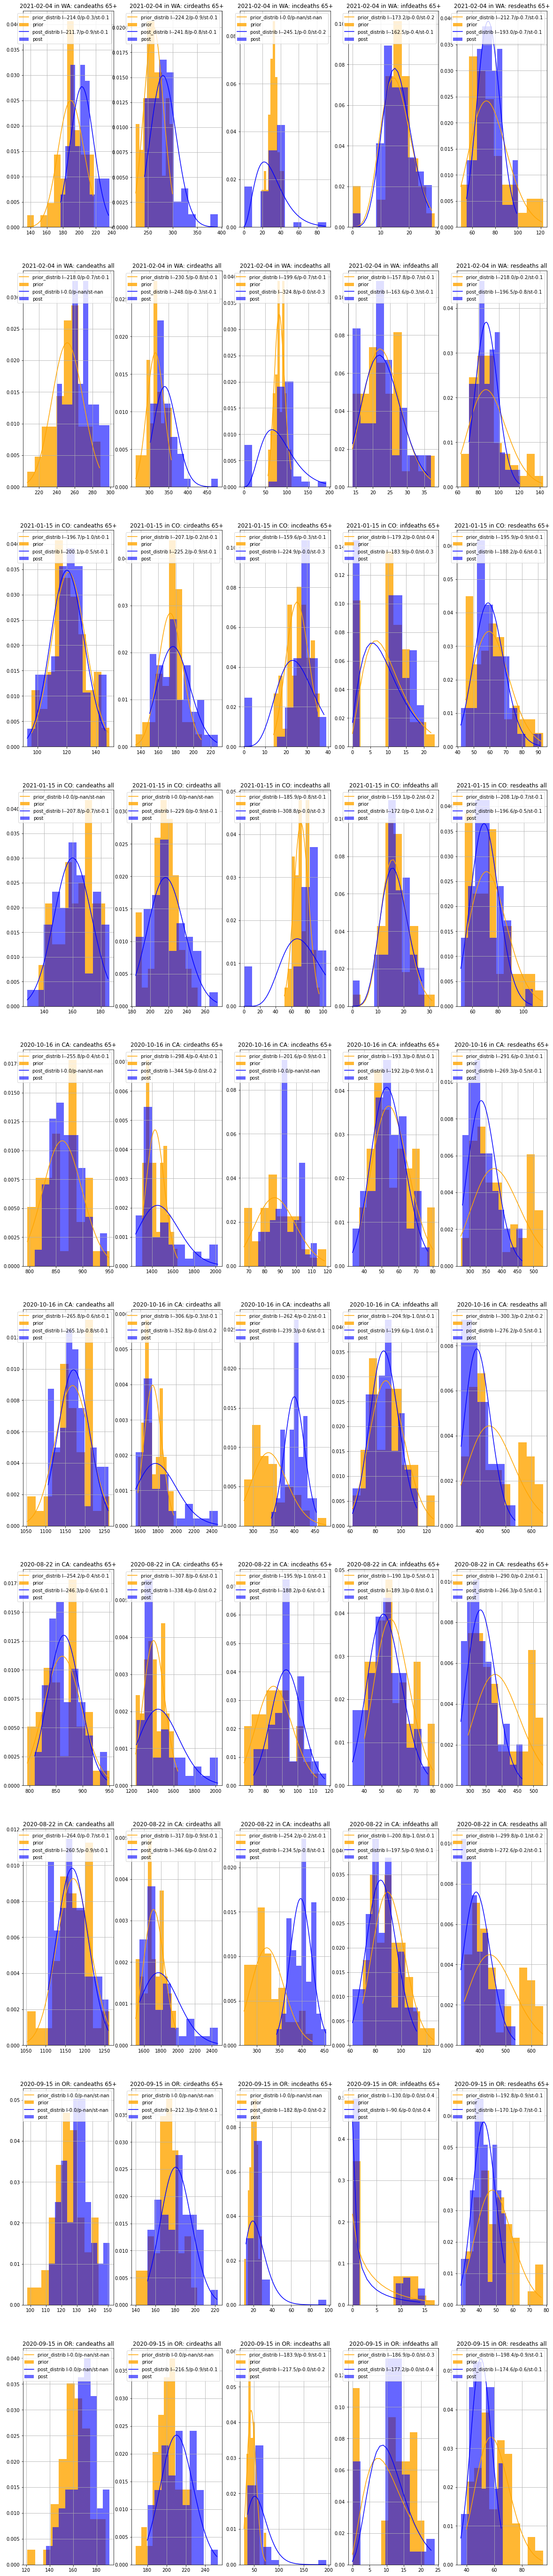

In [9]:
import matplotlib.pyplot as plt

sample_df = next(iter(next(iter(df_temporel.values())).values()))
columns = list(sample_df.select_dtypes(include=["int64"]).columns)
# do not include total
columns.remove("totaldeaths")

n_type_deaths = len(columns)
n_categories = len(next(iter(df_temporel)))
n_events = len(df_temporel)

n_lines = n_events * n_categories

fig, axs = plt.subplots(n_lines, n_type_deaths, figsize=(20, 100))

for index, (meta, df_dict) in enumerate(df_temporel.items()):
    time, location = meta
    date = str(time).split(" ")[0]

    for n_category, (category, df_) in enumerate(df_dict.items()):
        # df_ = df_dict['65+']

        for col, type_death in enumerate(columns):

            plot_hists(axs[index * n_categories + n_category, col], df_[type_death])

            axs[index * n_categories + n_category, col].legend()
            axs[index * n_categories + n_category, col].set_title(
                f"{date} in {location}: {type_death} {category}"
            )


plt.legend()

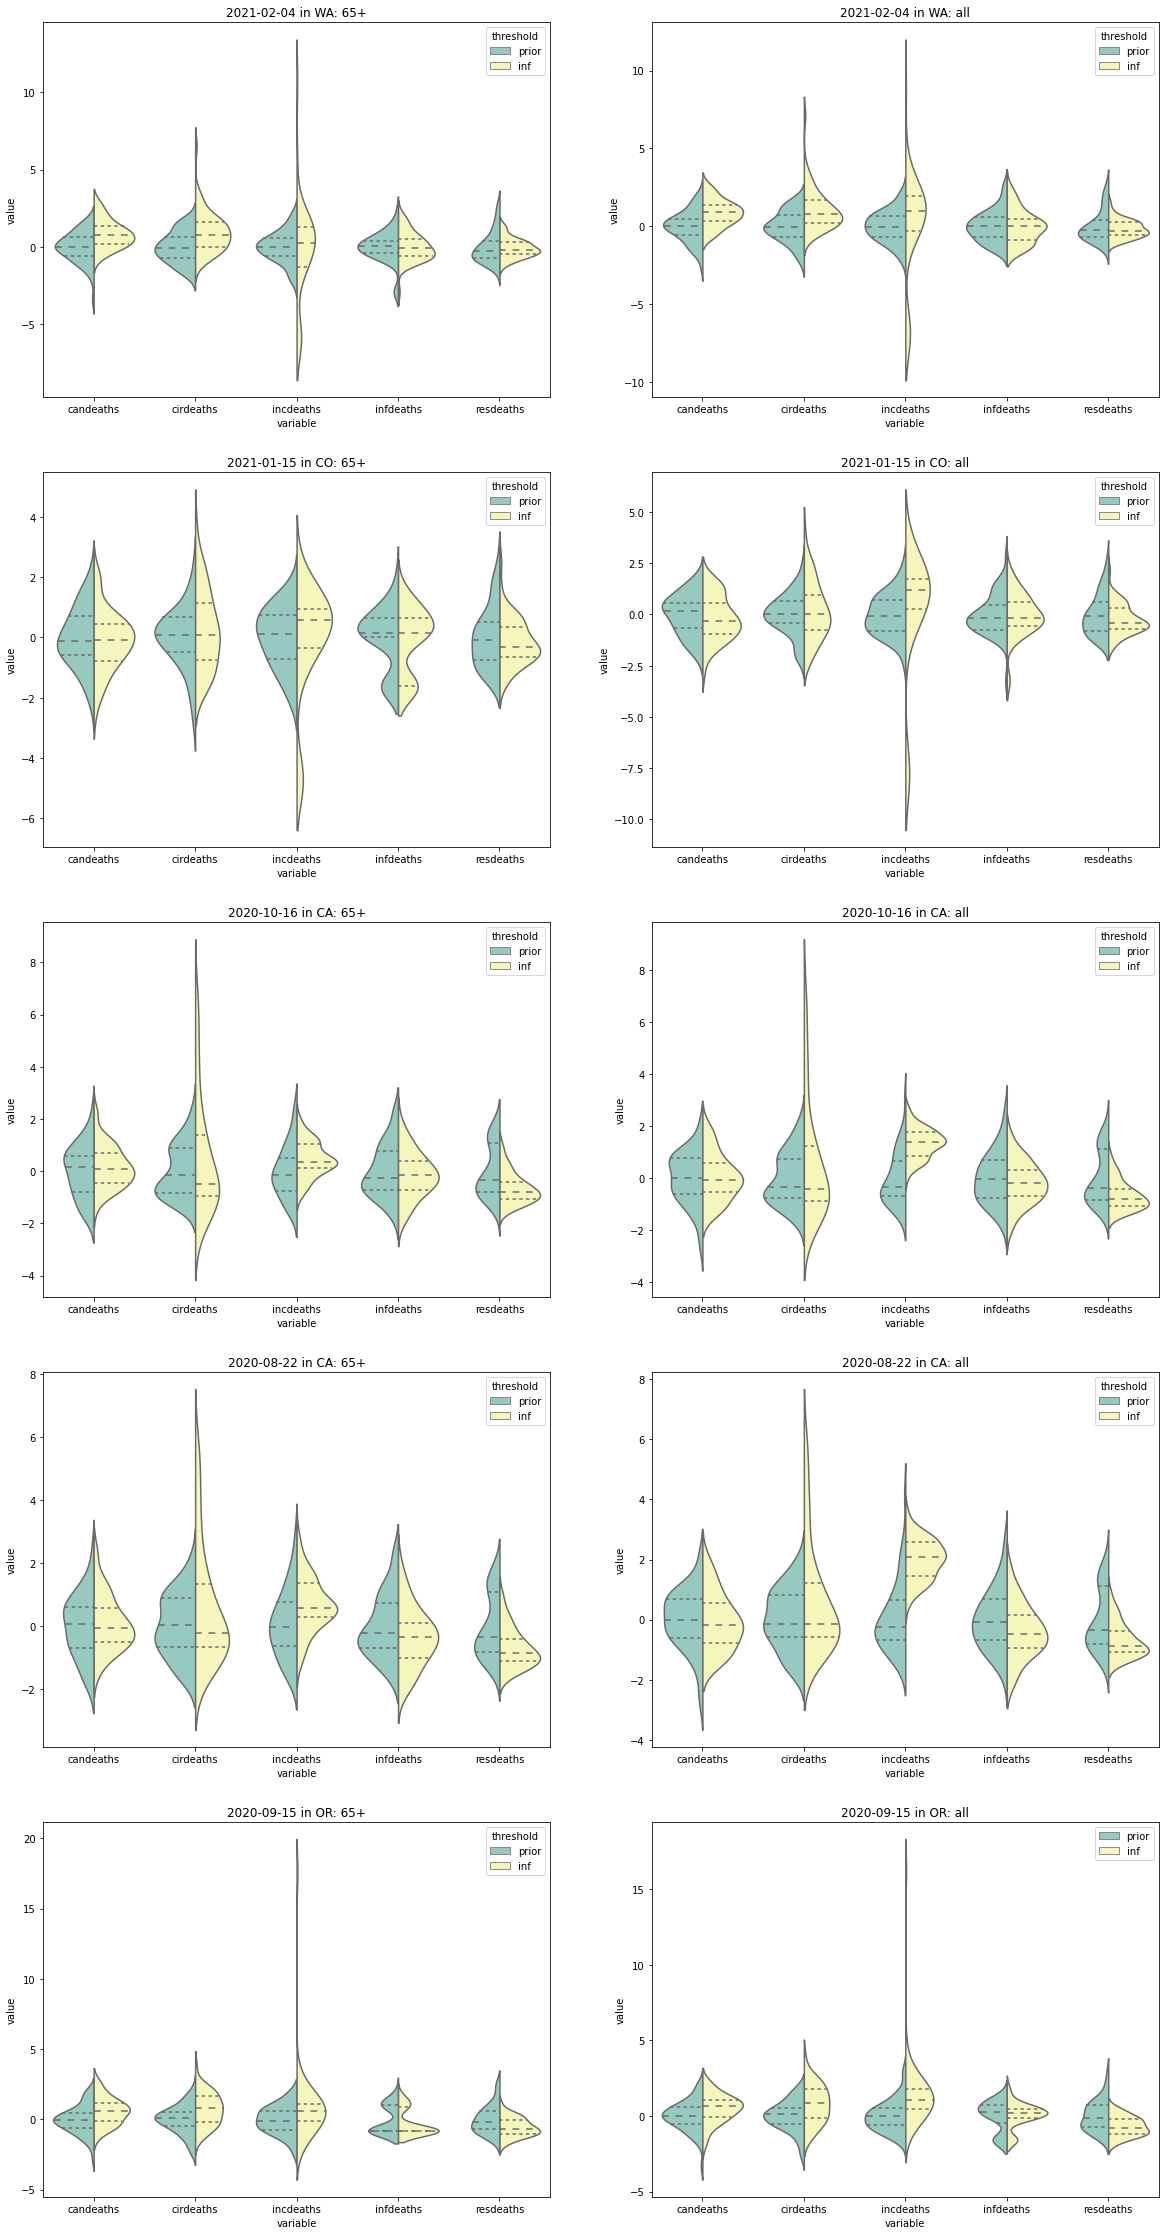

In [10]:
from IPython.display import clear_output

from utils import filter

for df_dict in df_temporel.values():
    for df_raw in df_dict.values():
        filter(df_raw)

n_categories = len(next(iter(df_temporel)))
n_lines = n_events

fig, axs = plt.subplots(n_lines, n_categories, figsize=(20, 40))

for index, (meta, df_dict) in enumerate(df_temporel.items()):
    time, location = meta
    date = str(time).split(" ")[0]

    for n_category, (category, df_) in enumerate(df_dict.items()):

        plot_boxs(axs[index, n_category], df_)
        axs[index, n_category].set_title(f"{date} in {location}: {category}")

clear_output()
plt.legend()

In [ ]:
#https://wonder.cdc.gov/controller/saved/D176/D296F145

## Temporal plots

In [69]:
from typing import Any, List
import pandas as pd



import numpy as np

from plotly.subplots import make_subplots
from plotly.validators.scatter.marker import SymbolValidator
import plotly.graph_objects as go
from typing import Dict

raw_symbols = SymbolValidator().values
namestems = []
namevariants = []
symbols = []
for i in range(0, len(raw_symbols), 3):
    name = raw_symbols[i + 2]
    symbols.append(raw_symbols[i])
    namestems.append(name.replace("-open", "").replace("-dot", ""))
    namevariants.append(name[len(namestems[-1]) :])

# def plot(df_temporel: Dict[pd.Timestamp: pd.DataFrame]):
"""Plot at each row death count in each category.

Args:
df_temporel (_type_): _description_
"""
rows = len(df_temporel)
cols = 2


# Create figure with secondary y-axis
fig = make_subplots(
    rows=rows,
    cols=2,
    specs=[[{"secondary_y": True}, {"secondary_y": True}] for _ in range(rows)],
)


def plot(fig:Any, df: pd.DataFrame, row:int, col:int, disaster_time:str, state: str, category:str, other_events:List[int]):
    # Left y
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df.cirdeaths,
            name="Diseases of the circulatory system",
            mode="markers",
            marker=dict(
                color="rgb(27,158,119)",
            ),
            marker_symbol=symbols[namestems.index("circle-cross")],
            marker_line_width=2,
            marker_size=10,
            # showlegend=False,
        ),
        secondary_y=False,
        row=row,
        col=col,
    )

    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df.cirFiltered,
            marker=dict(
                color="rgb(27,158,119)",
            ),
        ),
        secondary_y=False,
        row=row,
        col=col,
    )
    #Right y
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df.incdeaths,
            name="Incident related Deaths",
            mode="markers",
            marker_symbol=symbols[namestems.index("circle-x")],
            marker=dict(
                color="rgb(297,95,2)",
            ),
            marker_line_width=1.5,
            marker_size=10,
            # showlegend=False,
        ),
        secondary_y=True,
        row=row,
        col=col,
    )

    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df.incFiltered,
            marker=dict(
                color="rgb(297,95,2)",
            ),
        ),
        secondary_y=True,
        row=row,
        col=col,
    )

    # Set x-axis title
    fig.update_xaxes(title_text=f"{disaster_time} in {state} on {category}", range=[-365.0, 365], row=row, col=col)

    # Set y-axes titles
    if col%2:
        fig.update_yaxes(
        title_text='<b style="color:rgb(297,95,2)">Incident Axis x</b>',
        secondary_y=True, row=row, col=col,
    )
    else:
        fig.update_yaxes(
            title_text='<b style="color:rgb(27,158,119)">Circulatory axis &#10010;</b> ',
            secondary_y=False, row=row, col=col,
        )
    
    fig.add_vline(x=0.0, line_color="rgb(117,112,79)", line_dash="dash")
    [fig.add_vline(x=shift, line_color="rgb(117,112,79)", line_dash="dash") for shift in other_events]

In [70]:
from tqdm import tqdm

liste_ = list(df_temporel.keys())[:rows]


for row, (date, state) in enumerate(tqdm(liste_), start=1):
    shifts=[]
    max_shift = 365
    k = row-1
    
    time = str(date).split(" ")[0]
    for i in list(range(k-1,-1,-1))+list(range(k+1,len(liste_))):
        neighbor_time, neighbor_state = liste_[i]
        if neighbor_state==state:
            shifts.append(int((neighbor_time-pd.to_datetime(time))/ np.timedelta64(1, "D")))
        
    for col in [1, 2]:
        plot(
            fig=fig,
            df=df_temporel[(date, state)]["all"] if col % 2 else df_temporel[(date, state)]["65+"],
            row=row,
            col=col,
            disaster_time=time,
            state=state,
            other_events=shifts,
            category= "all" if col % 2 else "65+"
        )


fig.update_layout(title_text="Fire disasters", height= 1000*rows/3,plot_bgcolor='white')
fig.update_traces(showlegend=False)

# fig.update(layout_xaxis_range = [-365,365])

fig.show()

100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


## Tab metrics

In [ ]:
df__ =df_[(df_.date <= 365) & (df_.date >= -365)].cirdeaths.rolling(4, win_type='gaussian').mean(std=3)


100.*(df__[df__.index>0].max()-df__[df__.index<0].max())/df__[df__.index<0].max()